<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 7. Обучение без учителя
## <center>Часть 3. Кластеризация. Метод k-средних (k-means)

Метод k-means – это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.

Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.

Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам:
$$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$

Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости. 

Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1) *Этап кластеризациu.* На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2) *Этап обновления центроидов.* На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума – а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

### Пример: кластеризация игроков NBA

Про <a href="http://www.databasebasketball.com/about/aboutstats.htm">признаки</a> игроков.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

nba = pd.read_csv("../../data/nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


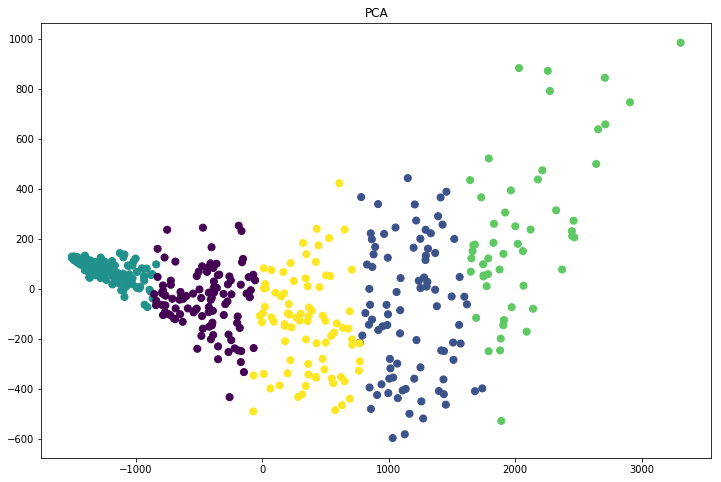

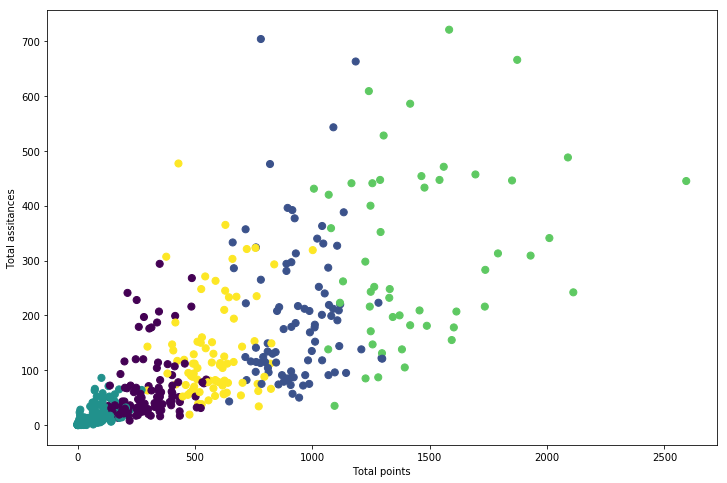

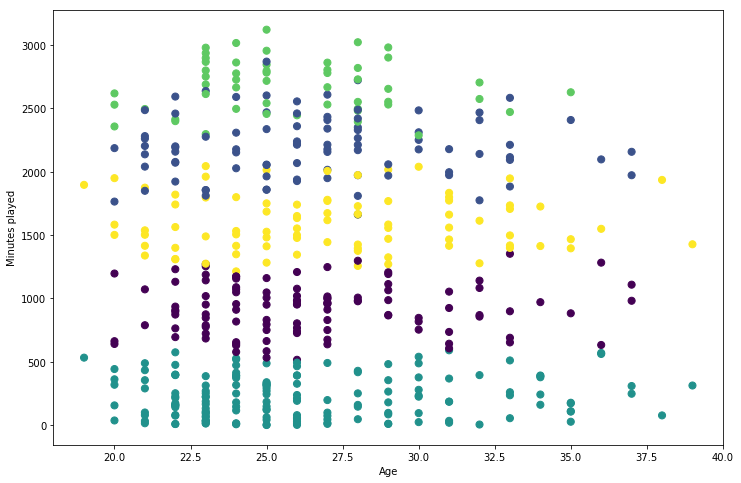

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=1)
numeric_cols = nba._get_numeric_data().dropna(axis=1)
kmeans.fit(numeric_cols)


# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(numeric_cols)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title('PCA')

# Visualizing using 2 features: Total points vs. Total assists
plt.figure(figsize=(12,8))
plt.scatter(nba['pts'], nba['ast'], c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('Total points')
plt.ylabel('Total assitances')

# Visualizing using 2 features: Age vs. Minutes played
plt.figure(figsize=(12,8))
plt.scatter(nba['age'], nba['mp'], c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('Age')
plt.ylabel('Minutes played');

### Инициализация центроидов

Метод `sklearn.KMeans` содержит параметры `n_init` (число запусков из различных начальных приближений) и `init`. Есть три способа инициализации центроидов:
- `k-means++` – "умная" инициализация центроидов для ускорения сходимости.
- `random` – случайная инициализация центроидов.
- `ndarray` – заданная инициализация центроидов.

## Сжатие изображений с K-means

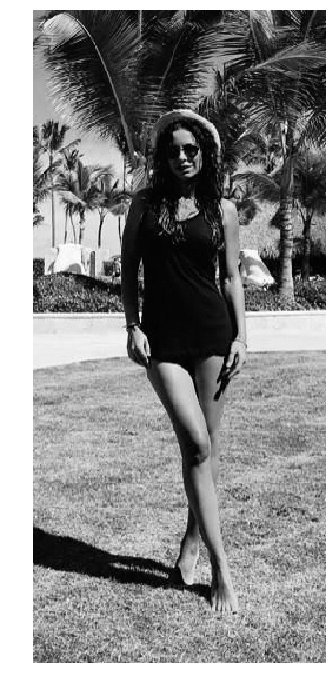

In [3]:
import matplotlib.image as mpimg
img = mpimg.imread('../../img/woman.jpg')[..., 1]
plt.figure(figsize = (20, 12))
plt.axis('off')
plt.imshow(img, cmap='gray');

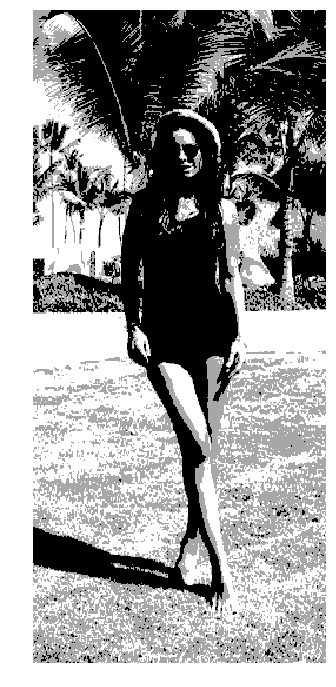

In [4]:
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import randint

X = img.reshape((-1, 1))
k_means = MiniBatchKMeans(n_clusters=3)
k_means.fit(X) 
values = k_means.cluster_centers_
labels = k_means.labels_
img_compressed = values[labels].reshape(img.shape)
plt.figure(figsize = (20, 12))
plt.axis('off')
plt.imshow(img_compressed, cmap = 'gray');

# Нахождение тем в текстах

**Применим KMeans для кластеризации текстов из 4 новостных категорий.**

In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from time import time

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space']

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

labels = dataset.target
true_k = np.unique(labels).shape[0]

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories


**Закодируем тексты с помощью TF-IDF признаков.**

In [6]:
print("Extracting features from the training dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english')

X = vectorizer.fit_transform(dataset.data)
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
n_samples: 3387, n_features: 1000


**И применим к получившимся векторам метод $k$ средних.**

In [ ]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


**Выведем слова, соответствующие самым весомым компонентам центров кластеров.**

In [ ]:
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

## Кластеризация рукописных цифр

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

In [ ]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

In [ ]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y, kmeans.predict(X))

In [ ]:
_, axes = plt.subplots(2, 5)
for ax, center in zip(axes.ravel(), kmeans.cluster_centers_):
    ax.matshow(center.reshape(8, 8), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

## Полезные ссылки
- <a href="https://en.wikipedia.org/wiki/K-means_clustering">k-means</a> на Википедии
- <a href="">Статья</a> про нечеткую кластеризацию городов по социально-экономическим показателям на Хабрахабре